<a href="https://colab.research.google.com/github/Saileshmurali/Machine-Learning/blob/main/Keyword_Spotter_Using_CNN/Keyword_Spotter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Only need to run this cell once per machine you get allocated (i.e. when your files get lost). 
# No need to re-run between different runtime refreshes.
!pip uninstall -y tensorflow tensorflow-estimator tensorboard
!pip install tensorflow==2.3.0
!curl https://raw.githubusercontent.com/eliberis/mcu-deployment-tutorial/master/speech_dataset.py > speech_dataset.py

Found existing installation: tensorflow 2.8.2+zzzcolab20220527125636
Uninstalling tensorflow-2.8.2+zzzcolab20220527125636:
  Successfully uninstalled tensorflow-2.8.2+zzzcolab20220527125636
Found existing installation: tensorflow-estimator 2.8.0
Uninstalling tensorflow-estimator-2.8.0:
  Successfully uninstalled tensorflow-estimator-2.8.0
Found existing installation: tensorboard 2.8.0
Uninstalling tensorboard-2.8.0:
  Successfully uninstalled tensorboard-2.8.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 320.4 MB 50 kB/s 
     |████████████████████████████████| 5.8 MB 6.3 MB/s 
     |████████████████████████████████| 2.9 MB 65.2 MB/s 
     |████████████████████████████████| 459 kB 63.5 MB/s 
     |████████████████████████████████| 20.1 MB 1.2 MB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.6
    Uninstalling numpy-1.21.6:
      Successfully uninstalled numpy-1.2

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 23051  100 23051    0     0   109k      0 --:--:-- --:--:-- --:--:--  109k


In [ ]:
import tensorflow as tf
print("Using TensorFlow version", tf.__version__)

from speech_dataset import SpeechDataset
dataset = SpeechDataset(words=["yes", "no"], silence_percentage=25, unknown_percentage=25)
batch_size = 128
train_data = dataset.training_dataset().batch(batch_size).prefetch(1) # .prefetch(1) preloads a batch onto a GPU
valid_data = dataset.validation_dataset().batch(batch_size).prefetch(1)

Using TensorFlow version 2.3.0
>> Downloading speech_commands_v0.02.tar.gz 100.0%INFO:tensorflow:Successfully downloaded speech_commands_v0.02.tar.gz (2428923189 bytes)


In [ ]:
# import matplotlib
# i = 0
# max = 0
# for spectrogram, label in dataset.testing_dataset().shuffle(50).take(15):
#   name = 'input'+str(i)
#   f=open('input'+str(i)+'.txt','w')
#   i = i+1
#   spectrogram, label = spectrogram.numpy(), label.numpy()
#   matplotlib.image.imsave(name+'.png', spectrogram[:,:,0].T, cmap='gray')
#   print(label)
#   k = 0
#   spectrogram = spectrogram[:,:,0].T
#   for j in spectrogram:
#     if k == 0:
#       f.write(str(j[0]))
#       k = k + 1
#     else:
#       f.write(','+str(j[0]))
#   b = np.max(spectrogram)
#   if max < b:
#     max = b
# for spectrogram, label in dataset.testing_dataset().shuffle(50).take(15):
#   f=open('input'+str(i)+'.c','w')
#   spectrogram, label = spectrogram.numpy(), label.numpy()
#   f.write("//Copy paste the value from here to main file as input for keyword spotter model\n")
#   f.write("q7_t data[]={\n")

0
2
3
3
3
0
2
1
0
3
1
2
3
2
2


Word: _unknown_


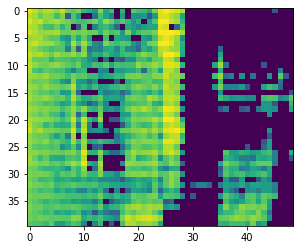

(49, 40, 1)
Word: no


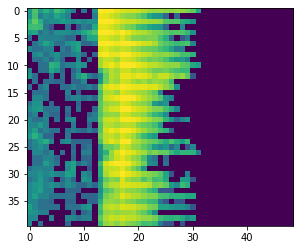

(49, 40, 1)
Word: no


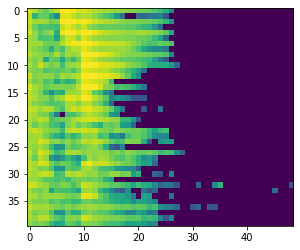

(49, 40, 1)
Word: _unknown_


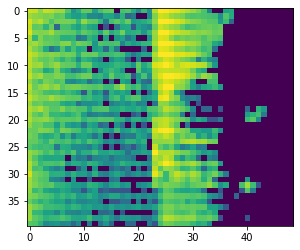

(49, 40, 1)
Word: no


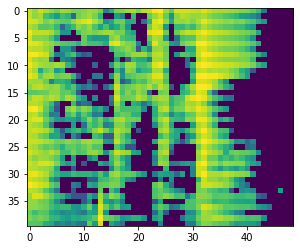

(49, 40, 1)


In [ ]:
import matplotlib.pyplot as plt
for spectrogram, label in dataset.testing_dataset().shuffle(50).take(5):
    spectrogram, label = spectrogram.numpy(), label.numpy()  # convert from Tensors to ndarrays
    print("Word:", dataset.look_up_word(label))
    plt.imshow(spectrogram[:, :, 0].T / 26.0, vmin=0.0, vmax=1.0)  # normalise back to 0.0 to 1.0
    plt.show()
    print(spectrogram.shape)

In [ ]:
input_shape = dataset.sample_shape()
num_classes = dataset.label_count()

In [ ]:
input_shape

(49, 40, 1)

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters = 32, kernel_size = (3, 3), strides=(1, 1), padding="SAME", activation="relu", input_shape=input_shape),
    tf.keras.layers.MaxPool2D(pool_size = (2,2)),
    tf.keras.layers.Conv2D(filters = 16, kernel_size = (3, 3), strides=(1, 1), padding="SAME", activation="relu"),
    tf.keras.layers.MaxPool2D(pool_size = (2,2)),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256),
    tf.keras.layers.Dense(num_classes, activation = 'softmax'),
])

model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 49, 40, 32)        320       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 24, 20, 32)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 24, 20, 16)        4624      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 12, 10, 16)        0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 12, 10, 16)        0         
_________________________________________________________________
flatten_12 (Flatten)         (None, 1920)              0         
_________________________________________________________________
dense_14 (Dense)             (None, 256)             

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

history = model.fit(train_data, validation_data=valid_data, epochs=10)  # you'd want to train for more epochs!

Epoch 1/10
75/75 [==============================] - 37s 490ms/step - loss: 1.7637 - accuracy: 0.6100 - val_loss: 0.5133 - val_accuracy: 0.8332
Epoch 2/10
75/75 [==============================] - 30s 398ms/step - loss: 0.5356 - accuracy: 0.8038 - val_loss: 0.4033 - val_accuracy: 0.8498
Epoch 3/10
75/75 [==============================] - 31s 408ms/step - loss: 0.4602 - accuracy: 0.8314 - val_loss: 0.3639 - val_accuracy: 0.8606
Epoch 4/10
75/75 [==============================] - 30s 401ms/step - loss: 0.4258 - accuracy: 0.8436 - val_loss: 0.3647 - val_accuracy: 0.8647
Epoch 5/10
75/75 [==============================] - 31s 412ms/step - loss: 0.4166 - accuracy: 0.8460 - val_loss: 0.3549 - val_accuracy: 0.8639
Epoch 6/10
75/75 [==============================] - 31s 414ms/step - loss: 0.3953 - accuracy: 0.8572 - val_loss: 0.3598 - val_accuracy: 0.8639
Epoch 7/10
75/75 [==============================] - 30s 406ms/step - loss: 0.3869 - accuracy: 0.8550 - val_loss: 0.3124 - val_accuracy: 0.8780

Text(0.5, 1.0, 'Training and validation loss')

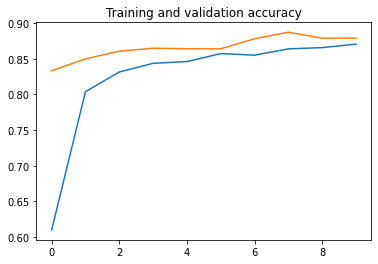

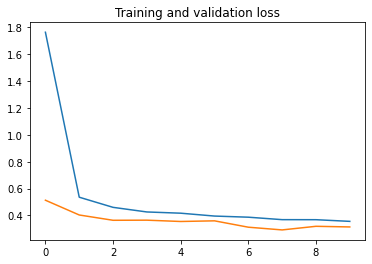

In [ ]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
acc      = history.history[     'accuracy' ]
val_acc  = history.history[ 'val_accuracy' ]
loss     = history.history[    'loss' ]
val_loss = history.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  ( epochs,     acc )
plt.plot  ( epochs, val_acc )
plt.title ('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  ( epochs,     loss )
plt.plot  ( epochs, val_loss )
plt.title ('Training and validation loss'   )

In [ ]:
test_data = dataset.testing_dataset().batch(64)
model.evaluate(test_data)
model.save("keyword_spotter.h5")

20/20 [==============================] - 3s 156ms/step - loss: 0.3030 - accuracy: 0.8908


In [ ]:
import tensorflow as tf
import numpy as np

def representative_dataset_gen():
    for sample, _ in dataset.validation_dataset():
        yield [np.expand_dims(sample, axis=0)]

import tensorflow as tf
model = tf.keras.models.load_model("keyword_spotter.h5")
converter = tf.lite.TFLiteConverter.from_keras_model(model)

converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8  
converter.inference_output_type = tf.int8
tflite_quant_model = converter.convert()

with open("model.tflite", "wb") as f:
    f.write(tflite_quant_model)

INFO:tensorflow:Assets written to: /tmp/tmp7c4h081_/assets


INFO:tensorflow:Assets written to: /tmp/tmp7c4h081_/assets


In [ ]:
import numpy as np

def evaluate(model_file, dataset):
    # Load the quantised TFLite model
    interpreter = tf.lite.Interpreter(model_path=model_file)
    interpreter.allocate_tensors()
    input_info = interpreter.get_input_details()[0]
    input_index = input_info["index"]
    scale, offset = input_info["quantization"]
    output_index = interpreter.get_output_details()[0]["index"]

    # Push the dataset through the model and compute accuracy
    accuracy = tf.keras.metrics.SparseCategoricalAccuracy()
    test_data = dataset.batch(1).as_numpy_iterator()

    for x, y_true in test_data:
        # The model expects a quantised input, spanning the entire range of int8
        x = (x / scale - offset).astype(np.int8)
        interpreter.set_tensor(input_index, x)
        interpreter.invoke()
        y_pred = interpreter.get_tensor(output_index)
        accuracy.update_state(y_true, y_pred)
    return accuracy.result()

accuracy = evaluate("model.tflite", dataset.testing_dataset())
print(f"accuracy (quantised model) = {accuracy:.4f}")

accuracy (quantised model) = 0.8883


In [ ]:
!apt-get -qq install xxd
!echo "Exporting model. Model size (in bytes):" 
!stat --printf="%s" model.tflite
!xxd -i model.tflite > model.cc

Exporting model. Model size (in bytes):
504320